In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
crime_01_04 = pd.read_csv('Chicago_Crimes_2001_to_2004.csv', sep=",", error_bad_lines=False, low_memory=False)
crime_05_07 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv', sep=",", error_bad_lines=False, low_memory=False)
crime_08_11 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv', sep=",", error_bad_lines=False, low_memory=False)
crime_12_17 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', sep=",", error_bad_lines=False, low_memory=False)

Skipping line 1513591: expected 23 fields, saw 24

Skipping line 533719: expected 23 fields, saw 24

Skipping line 1149094: expected 23 fields, saw 41



In [4]:
crime = pd.concat([crime_01_04,crime_05_07, crime_08_11, crime_12_17],axis=0)

In [16]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7941282 entries, 0 to 1456713
Data columns (total 23 columns):
Unnamed: 0              int64
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            object
Year                    float64
Updated On              object
Latitude                object
Longitude               float64
Location                object
dtypes: bool(2), float64(6), int64(3), object(12)
memory usage: 1.3+ GB


In [17]:
crime.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.0,61.0,26,1173974.0,1876757.0,2003.0,04/15/2016 08:55:02 AM,41.817229156,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927,4789765,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,...,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302,4677901,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,...,34.0,49.0,06,1174948.0,1831051.0,2003.0,04/15/2016 08:55:02 AM,41.691784636,-87.635116,"(41.691784636, -87.635115968)"


In [18]:
crime.isna().sum()

Unnamed: 0                   0
ID                           0
Case Number                  7
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64

In [5]:
# team to remove additional columns as appropriate
crime = crime.drop(['Unnamed: 0','Updated On','Case Number', 'IUCR', 'Location'],axis=1)
crime = crime[pd.notnull(crime['Location Description'])]
crime = crime[pd.notnull(crime['District'])]

In [7]:
crime_type = pd.get_dummies(crime['Primary Type'],drop_first=True)
arrest = pd.get_dummies(crime['Arrest'],drop_first=True)
location = pd.get_dummies(crime['Location Description'],drop_first=True)
dom = pd.get_dummies(crime['Domestic'],drop_first=True)
district = pd.get_dummies(crime['District'],drop_first=True)
crime_mod = pd.concat([crime,crime_type,arrest,location,dom],axis=1)


In [21]:
crime.describe

<bound method DataFrame.describe of                ID                    Date                    Block  \
0         4786321  01/01/2004 12:01:00 AM        082XX S COLES AVE   
1         4676906  03/01/2003 12:00:00 AM          004XX W 42ND PL   
2         4789749  06/20/2004 11:00:00 AM      025XX N KIMBALL AVE   
3         4789765  12/30/2004 08:00:00 PM       045XX W MONTANA ST   
4         4677901  05/01/2003 01:00:00 AM       111XX S NORMAL AVE   
5         4838048  08/01/2004 12:01:00 AM      012XX S HARDING AVE   
6         4791194  01/01/2001 11:00:00 AM  114XX S ST LAWRENCE AVE   
7         4679521  03/15/2003 12:00:00 AM       090XX S RACINE AVE   
8         4792195  09/16/2004 10:00:00 AM       003XX W HUBBARD ST   
9         4680124  01/01/2003 12:00:00 AM    009XX S SPAULDING AVE   
10        4682244  06/05/2003 12:00:00 AM       093XX S WALLACE ST   
11        4795453  11/01/2004 12:01:00 AM     058XX N WINTHROP AVE   
12        4684808  01/01/2003 12:00:00 AM       060XX 

In [22]:
crime.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
0,4786321,01/01/2004 12:01:00 AM,082XX S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,7.0,46.0,06,NaN,NaN,2004.0,NaN,NaN
1,4676906,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1876757.0,2003.0,41.817229156,-87.637328
2,4789749,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,1413,14.0,35.0,22.0,20,NaN,NaN,2004.0,NaN,NaN
3,4789765,12/30/2004 08:00:00 PM,045XX W MONTANA ST,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,2521,25.0,31.0,20.0,06,NaN,NaN,2004.0,NaN,NaN
4,4677901,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1831051.0,2003.0,41.691784636,-87.635116


In [23]:
# For Location Analysis if analysis is done on latitude/longitude - filtered for only reports with latitude/longitude
# if we want comprehensive data, then Beat would be the best (no null values) I kept all location columns for now but please remove as appropriate.
# I kept all location columns for now but please remove as appropriate
crime_coord = crime[crime.Latitude.notnull()]
crime_coord.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
1,4676906,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1876757.0,2003.0,41.817229156,-87.637328
4,4677901,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1831051.0,2003.0,41.691784636,-87.635116
6,4791194,01/01/2001 11:00:00 AM,114XX S ST LAWRENCE AVE,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,531,5.0,9.0,50.0,02,1182247.0,1829375.0,2001.0,41.687020002,-87.608445
7,4679521,03/15/2003 12:00:00 AM,090XX S RACINE AVE,OTHER OFFENSE,OTHER WEAPONS VIOLATION,RESIDENCE PORCH/HALLWAY,False,False,2222,22.0,21.0,73.0,26,1169911.0,1844832.0,2003.0,41.729712374,-87.653159
9,4680124,01/01/2003 12:00:00 AM,009XX S SPAULDING AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,1134,11.0,24.0,29.0,06,1154521.0,1895755.0,2003.0,41.869772159,-87.708180


In [8]:
# Split Date into Month, Date, Year, Time

new = crime["Date"].str.split("/", n = 2, expand = True)
crime["Month"] = new[0]
crime["Date"] = new[1]
new2 = new[2].str.split(" ", n = 1, expand = True)
crime["Year"] = new2[0]
crime["Time"] = new2[1]
crime.head()


,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Month,Time
0,4786321,01,082XX S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,7.0,46.0,06,NaN,NaN,2004,NaN,NaN,01,12:01:00 AM
1,4676906,01,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1876757.0,2003,41.817229156,-87.637328,03,12:00:00 AM
2,4789749,20,025XX N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,1413,14.0,35.0,22.0,20,NaN,NaN,2004,NaN,NaN,06,11:00:00 AM
3,4789765,30,045XX W MONTANA ST,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,2521,25.0,31.0,20.0,06,NaN,NaN,2004,NaN,NaN,12,08:00:00 PM
4,4677901,01,111XX S NORMAL AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1831051.0,2003,41.691784636,-87.635116,05,01:00:00 AM


<Figure size 432x288 with 0 Axes>

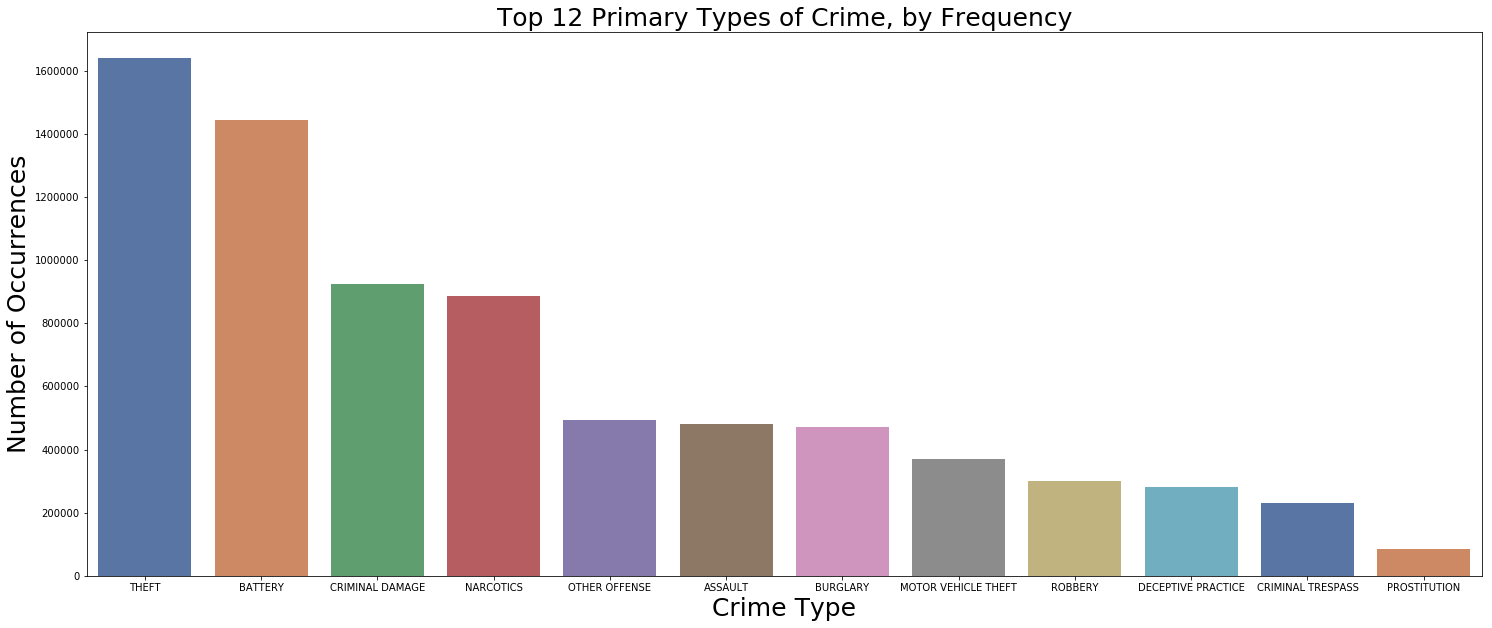

In [125]:
crimeFrequency = crime['Primary Type'].value_counts()[:12]
plt.figure()
plt.figure(figsize=(25,10))
sns.barplot(crimeFrequency.index, crimeFrequency.values, palette = "deep")
plt.title('Top 12 Primary Types of Crime, by Frequency',fontsize = "25")
plt.ylabel('Number of Occurrences',fontsize = "25")
plt.xlabel('Crime Type',fontsize = "25")
plt.show()

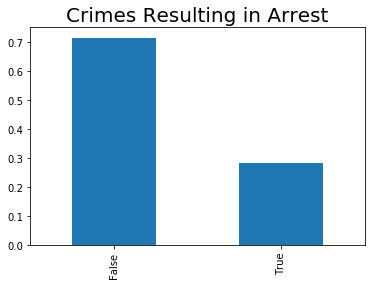

In [122]:
crime['Arrest'].value_counts(normalize=True).plot.bar()
plt.title("Crimes Resulting in Arrest", fontsize = "20")
plt.show()


<Figure size 432x288 with 0 Axes>

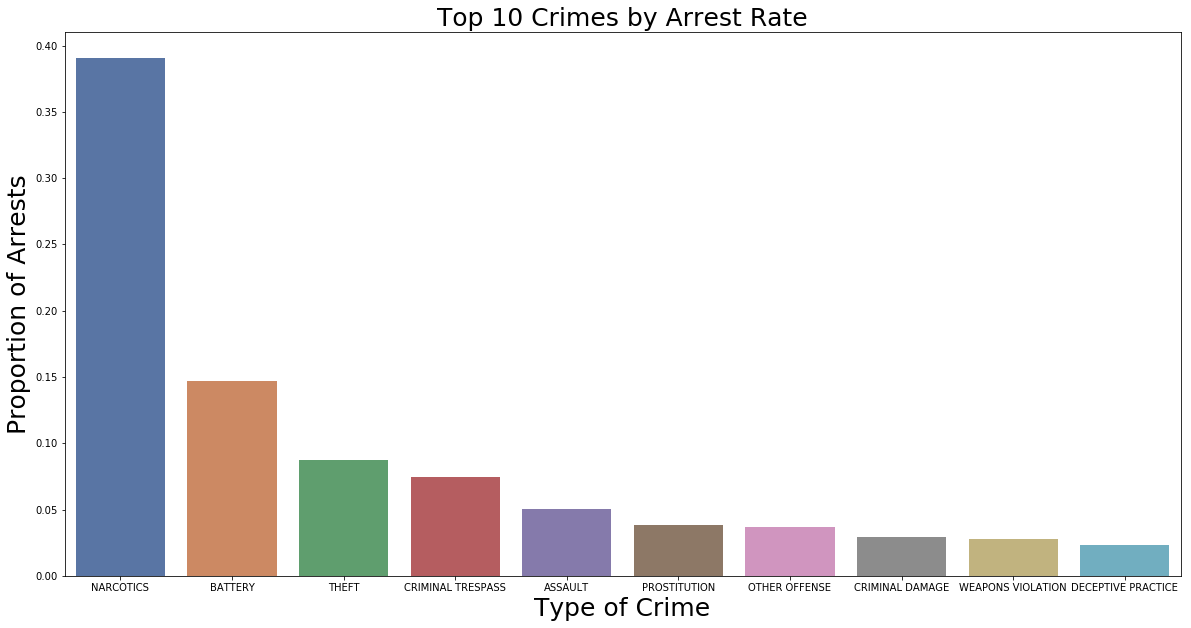

In [126]:
arrests = crime[crime.Arrest == True]['Primary Type'].value_counts(normalize=True).head(10)
plt.figure()
plt.figure(figsize=(20,10))
sns.barplot(arrests.index, arrests.values, palette = "deep")
plt.title("Top 10 Crimes by Arrest Rate",fontsize = "25")
plt.xlabel('Type of Crime',fontsize = "25")
plt.ylabel('Proportion of Arrests',fontsize = "25")
plt.show()

<Figure size 432x288 with 0 Axes>

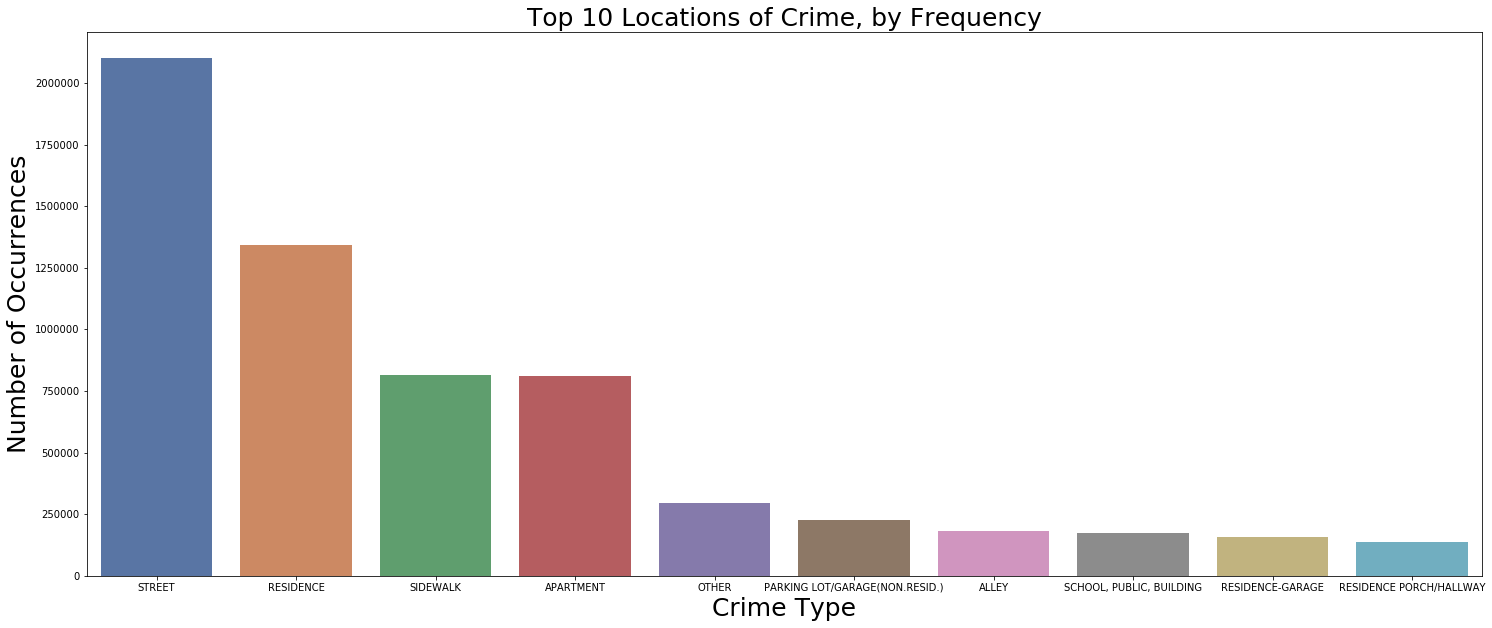

In [127]:
crimeLocation = crime['Location Description'].value_counts()[:10]
plt.figure()
plt.figure(figsize=(25,10))
sns.barplot(crimeLocation.index, crimeLocation.values, palette = "deep")
plt.title('Top 10 Locations of Crime, by Frequency',fontsize = "25")
plt.ylabel('Number of Occurrences',fontsize = "25")
plt.xlabel('Crime Type',fontsize = "25")
plt.show()

Text(0,0.5,'Number of Occurrences')

<Figure size 432x288 with 0 Axes>

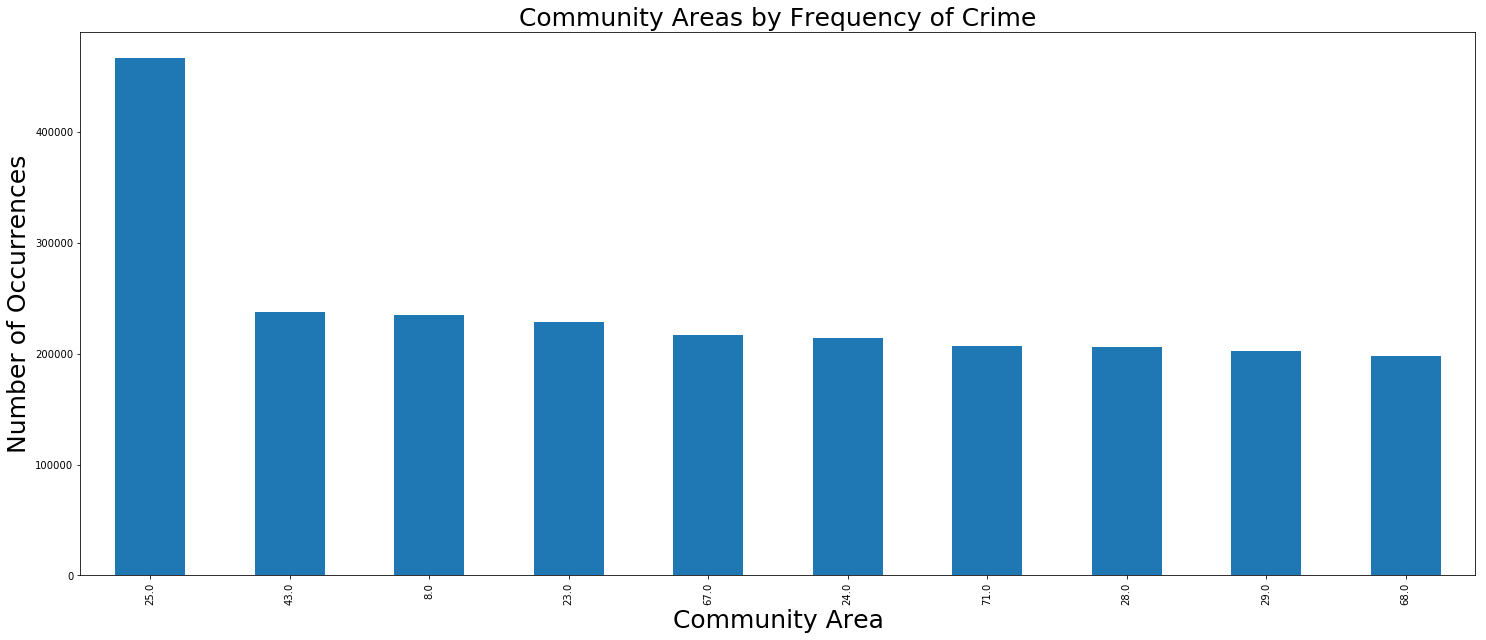

In [162]:
plt.figure()
plt.figure(figsize=(25,10))
crime['Community Area'].value_counts().head(10).plot.bar()
plt.title('Community Areas by Frequency of Crime',fontsize = "25")
plt.xlabel('Community Area',fontsize = "25")
plt.ylabel('Number of Occurrences',fontsize = "25")

Text(0,0.5,'Number of Homicides')

<Figure size 432x288 with 0 Axes>

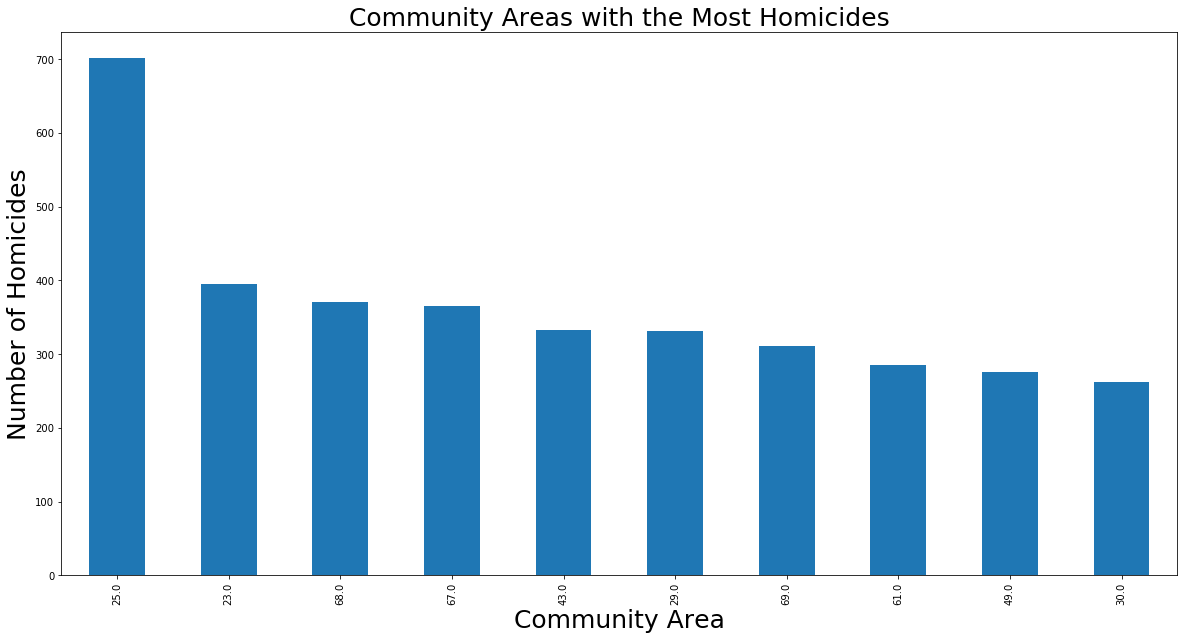

In [163]:
plt.figure()
plt.figure(figsize=(20,10))
crime[crime['Primary Type'] == 'HOMICIDE']['Community Area'].value_counts().head(10).plot.bar()
plt.title("Community Areas with the Most Homicides", fontsize = 25)
plt.xlabel('Community Area', fontsize = 25)
plt.ylabel('Number of Homicides', fontsize = 25)

Text(0.5,1,'Chicago Homicide Rates (2001 - 2017)')

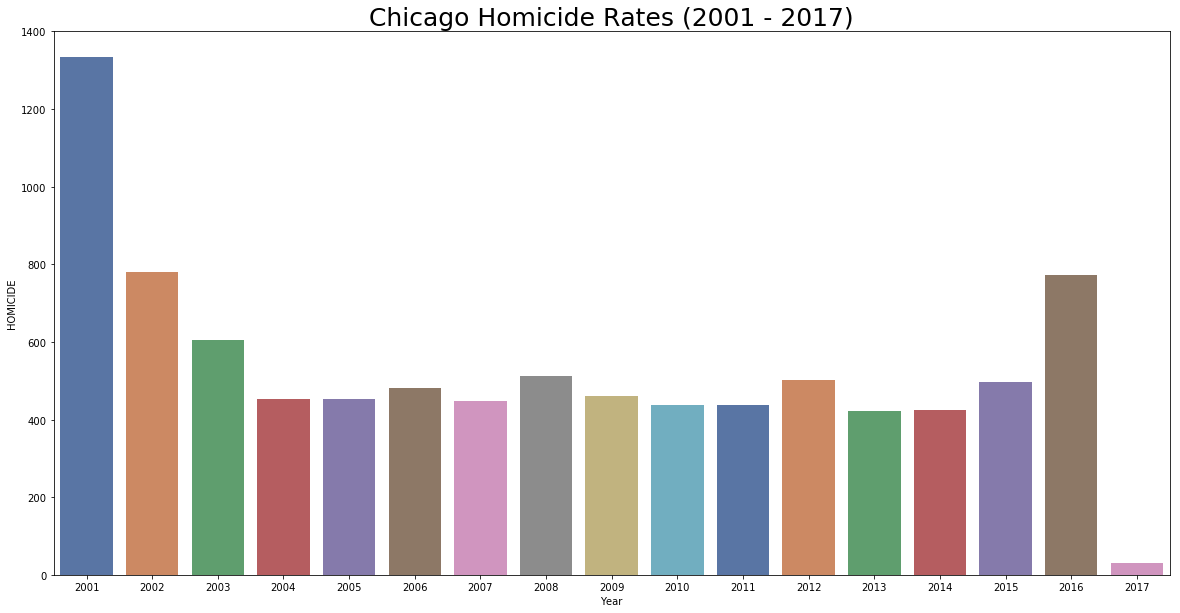

In [130]:
homicide = crime[crime['Primary Type']=='HOMICIDE']
plt.figure(figsize=(20,10))
sns.barplot(x='Year', y='HOMICIDE', data=homicide.groupby(['Year'])['Primary Type'].value_counts().unstack().reset_index(),palette = "deep")
plt.title("Chicago Homicide Rates (2001 - 2017)",fontsize = "25")

Text(0.5,1,'Annual Homicide - Arrest vs. No Arrest')

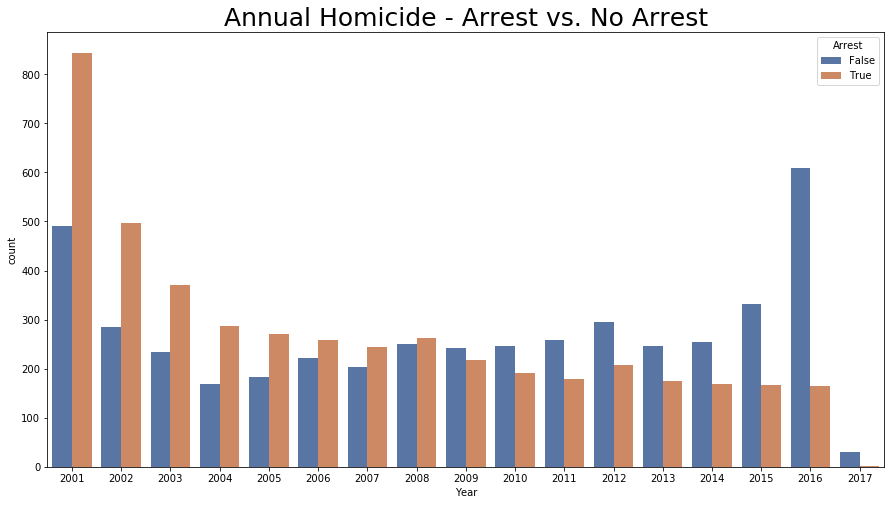

In [131]:
plt.subplots(figsize=(15,8))
arrestHomicide = homicide[['Year','Arrest']]
sns.countplot(x="Year", hue='Arrest', data = arrestHomicide, palette="deep")
plt.title('Annual Homicide - Arrest vs. No Arrest',fontsize = "25")


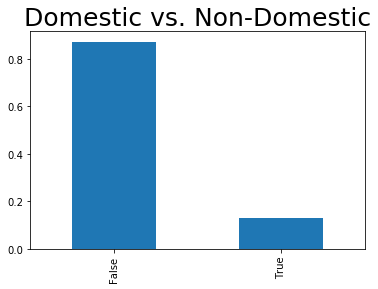

In [132]:
crime['Domestic'].value_counts(normalize=True).plot.bar()
plt.title("Domestic vs. Non-Domestic",fontsize = "25")
plt.show()

Text(0,0.5,'Number of Crimes')

<Figure size 1440x720 with 0 Axes>

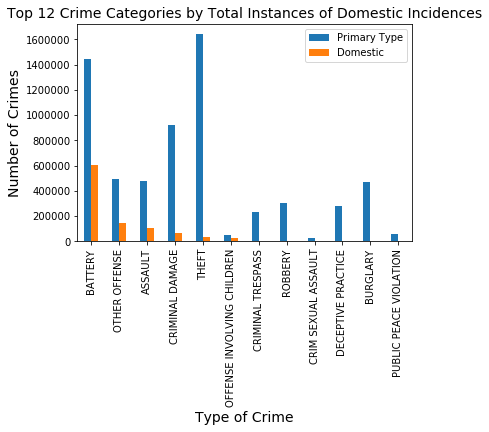

In [142]:
df1 = crime.groupby('Primary Type')[['Primary Type']].count()
df2 = crime.groupby('Primary Type')[['Domestic']].sum()
plt.figure(figsize=(20,10))
pd.concat([df1, df2], axis = 1).sort_values('Domestic', ascending=False).head(12).plot.bar()
plt.title("Top 12 Crime Categories by Total Instances of Domestic Incidences",fontsize = "14")
plt.xlabel('Type of Crime',fontsize = "14")
plt.ylabel('Number of Crimes',fontsize = "14")

In [154]:
descriptions = crime.groupby(['Primary Type','Description']).size().reset_index().rename(columns={0:'count'})
descriptions[descriptions['Primary Type']=='OTHER OFFENSE'].sort_values('count', ascending=False).head(10)

,Primary Type,Description,count
290,OTHER OFFENSE,TELEPHONE THREAT,164930
272,OTHER OFFENSE,HARASSMENT BY TELEPHONE,121077
281,OTHER OFFENSE,OTHER VEHICLE OFFENSE,41486
294,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,38193
266,OTHER OFFENSE,FALSE/STOLEN/ALTERED TRP,25678
271,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,23084
280,OTHER OFFENSE,OTHER CRIME INVOLVING PROPERTY,13749
282,OTHER OFFENSE,OTHER WEAPONS VIOLATION,9771
292,OTHER OFFENSE,VEHICLE TITLE/REG OFFENSE,8142
279,OTHER OFFENSE,OTHER CRIME AGAINST PERSON,7541


,Year,Arrest
1438,2001,False
1445,2001,False
1450,2001,True
1457,2001,True
1468,2001,False
1476,2001,False
1485,2001,True
1499,2001,True
1507,2001,False
1516,2001,False
